# Object Recognition with Inception CNN

Machine learning, in particular, deep learning is awesome in what it can accomplish. It is also computationally taxing and training a convolutional neural network on 1,200,000 images could take months on a laptop. Luckily, Google has not only developed their own Python library for deep learning, Tensorflow, and shared it with everyone, but they have also shared their own networks that have already been trained on the 1.2 million images across 1000 different classes in ImageNet. 

Download the [tensorflow models repository](https://github.com/tensorflow/models) and do all the work in the slim folder. Create a new folder called images to store the pictures for classification. 

First step is to download the appropriate models from tensorflow. The list of models can be found on the [tensorflow models GitHub](https://github.com/tensorflow/models/tree/master/slim#pre-trained-models). To download additional models, simply replace the model url with the desired model url. 

## Download latest checkpoint of pre-trained models

In [2]:
import tensorflow as tf
from datasets import dataset_utils
import os

# Base url
TF_MODELS_URL = "http://download.tensorflow.org/models/"

# Modify this path for a different CNN
INCEPTION_V3_URL = TF_MODELS_URL + "inception_v3_2016_08_28.tar.gz"
INCEPTION_V4_URL = TF_MODELS_URL + "inception_v4_2016_09_09.tar.gz"

# Directory to save model checkpoints
MODELS_DIR = "models/cnn"

INCEPTION_V3_CKPT_PATH = MODELS_DIR + "/inception_v3.ckpt"
INCEPTION_V4_CKPT_PATH = MODELS_DIR + "/inception_v4.ckpt"

# Make the model directory if it does not exist
if not tf.gfile.Exists(MODELS_DIR):
    tf.gfile.MakeDirs(MODELS_DIR)
 
# Download the appropriate model if haven't already done so
if not os.path.exists(INCEPTION_V3_CKPT_PATH):    
    dataset_utils.download_and_uncompress_tarball(INCEPTION_V3_URL, MODELS_DIR)
    
if not os.path.exists(INCEPTION_V4_CKPT_PATH):
    dataset_utils.download_and_uncompress_tarball(INCEPTION_V4_URL, MODELS_DIR)

>> Downloading inception_v3_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v3_2016_08_28.tar.gz 100885009 bytes.
>> Downloading inception_v4_2016_09_09.tar.gz 100.0%
Successfully downloaded inception_v4_2016_09_09.tar.gz 171177982 bytes.


## Process the images into correct format

In [2]:
from preprocessing import inception_preprocessing
# This can be modified depending on the model used and the training image dataset

def process_image(image):
    root_dir = "images/"
    filename = root_dir + image
    with open(filename, "rb") as f:
        image_str = f.read()
        
    if image.endswith('jpg'):
        raw_image = tf.image.decode_jpeg(image_str, channels=3)
    elif image.endswith('png'):
        raw_image = tf.image.decode_png(image_str, channels=3)
    else: 
        print("Image must be either jpg or png")
        return 
    
    image_size = 299 # ImageNet image size, different models may be sized differently
    processed_image = inception_preprocessing.preprocess_image(raw_image, image_size,
                                                             image_size, is_training=False)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        raw_image, processed_image = sess.run([raw_image, processed_image])
        
    return raw_image, processed_image.reshape(-1, 299, 299, 3)

## Write a function to display images

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_color_image(image):
    plt.figure(figsize=(10,10))
    plt.imshow(image.astype(np.uint8), interpolation='nearest')
    plt.axis('off')


## Several representative images

In [4]:
raw_bison, processed_bison = process_image('bison.jpg')

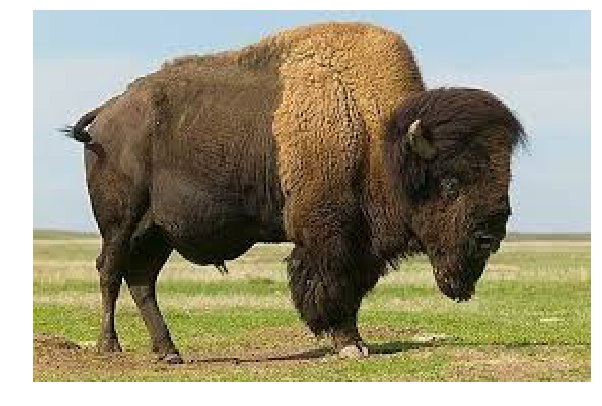

In [5]:
plot_color_image(raw_bison)

In [6]:
raw_sombrero, processed_sombrero = process_image('sombrero.jpg')

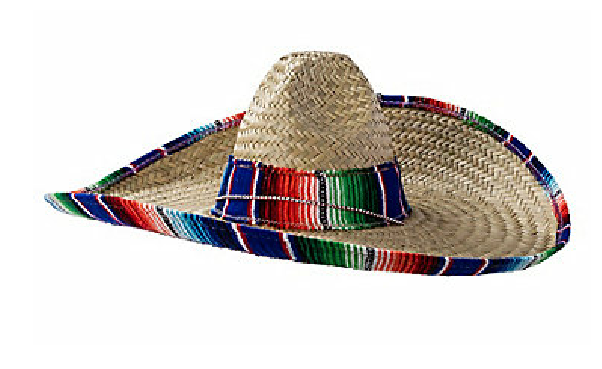

In [7]:
plot_color_image(raw_sombrero)

In [8]:
print(raw_bison.shape, processed_bison.shape)

(183, 275, 3) (1, 299, 299, 3)


Alright, it looks like the images are being properly formatted for use in the convolutional neural net. In the case of the bison image, because it is originally too small, the preprocessing function adds extra pixels by interpolating the colr value from surrounding pixels. 

## Load the Pre-Trained Architecture and Model Weights and Make Predictions

In [9]:
from datasets import imagenet
from tensorflow.contrib import slim
from nets import inception

In [10]:
'''
predict(image, version) bFunction takes in the name of the image and optionally the network to use for predictions
Currently, the only options for the net are Inception V3 and Inception V4.
Plots the raw image and displays the top-10 class predictions.
'''

def predict(image, version='V3'):
    tf.reset_default_graph()
    
    # Process the image 
    raw_image, processed_image = process_image(image)
    class_names = imagenet.create_readable_names_for_imagenet_labels()
    
    # Create a placeholder for the images
    X = tf.placeholder(tf.float32, [None, 299, 299, 3], name="X")
    
    '''
    inception_v3 function returns logits and end_points dictionary
    logits are output of the network before applying softmax activation
    '''
    
    if version.upper() == 'V3':
        model_ckpt_path = INCEPTION_V3_CKPT_PATH
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            # Set the number of classes and is_training parameter  
            logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=False)
            
    elif version.upper() == 'V4':
        model_ckpt_path = INCEPTION_V4_CKPT_PATH
        with slim.arg_scope(inception.inception_v3_arg_scope()):
            # Set the number of classes and is_training parameter
            # Logits 
            logits, end_points = inception.inception_v4(X, num_classes=1001, is_training=False)
            
    
    predictions = end_points.get('Predictions', 'No key named predictions')
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        saver.restore(sess, model_ckpt_path)
        prediction_values = predictions.eval({X: processed_image})
        
    try:
        # Add an index to predictions and then sort by probability
        prediction_values = [(i, prediction) for i, prediction in enumerate(prediction_values[0,:])]
        prediction_values = sorted(prediction_values, key=lambda x: x[1], reverse=True)
        
        # Plot the image
        plot_color_image(raw_image)
        plt.show()
        print("Using Inception_{} CNN\nPrediction: Probability\n".format(version))
        # Display the image and predictions 
        for i in range(10):
            predicted_class = class_names[prediction_values[i][0]]
            probability = prediction_values[i][1]
            print("{}: {:.2f}%".format(predicted_class, probability*100))
    
    # If the predictions do not come out right
    except:
        print(predictions)

## Test Inception Object Recoginition

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt


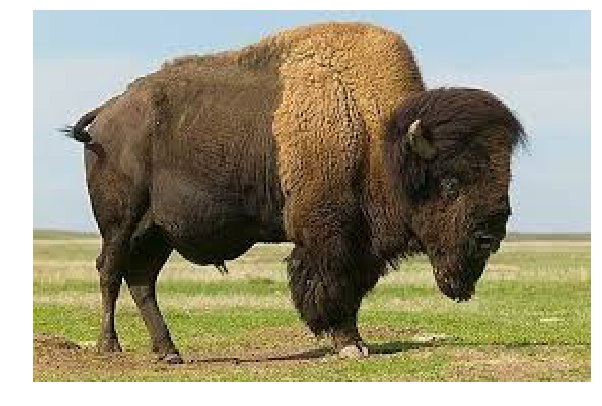

Using Inception_V3 CNN
Prediction: Probability

bison: 93.83%
ox: 0.13%
ibex, Capra ibex: 0.05%
rhinoceros beetle: 0.05%
brown bear, bruin, Ursus arctos: 0.03%
ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle: 0.03%
Leonberg: 0.03%
promontory, headland, head, foreland: 0.03%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 0.03%
wool, woolen, woollen: 0.03%


In [11]:
predict('bison.jpg', version='V3')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


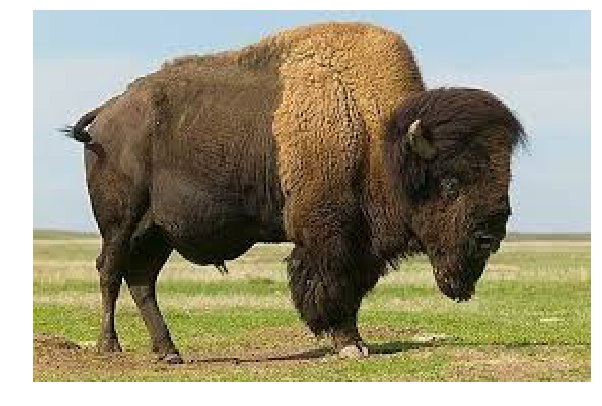

Using Inception_V4 CNN
Prediction: Probability

bison: 93.07%
ox: 0.11%
face powder: 0.07%
Arabian camel, dromedary, Camelus dromedarius: 0.06%
gorilla, Gorilla gorilla: 0.04%
Bouvier des Flandres, Bouviers des Flandres: 0.03%
spotlight, spot: 0.03%
pencil sharpener: 0.03%
ibex, Capra ibex: 0.03%
Irish water spaniel: 0.03%


In [12]:
predict('bison.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


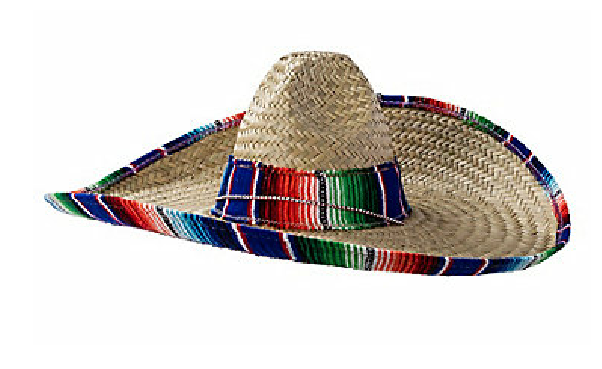

Using Inception_V4 CNN
Prediction: Probability

sombrero: 99.86%
cowboy hat, ten-gallon hat: 0.13%
maraca: 0.00%
bonnet, poke bonnet: 0.00%
revolver, six-gun, six-shooter: 0.00%
poncho: 0.00%
sunscreen, sunblock, sun blocker: 0.00%
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis: 0.00%
cowboy boot: 0.00%
banjo: 0.00%


In [13]:
predict('sombrero.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v3.ckpt


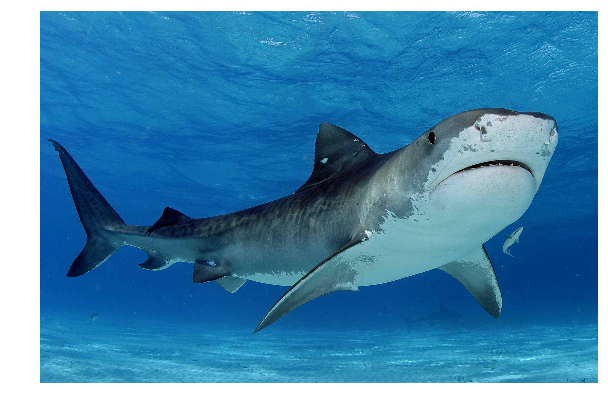

Using Inception_V3 CNN
Prediction: Probability

tiger shark, Galeocerdo cuvieri: 97.53%
scale, weighing machine: 0.74%
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias: 0.04%
scuba diver: 0.02%
hammerhead, hammerhead shark: 0.01%
Norwich terrier: 0.01%
Australian terrier: 0.01%
cairn, cairn terrier: 0.01%
axolotl, mud puppy, Ambystoma mexicanum: 0.01%
hot pot, hotpot: 0.01%


In [14]:
predict('tiger-shark.jpg', version='V3')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


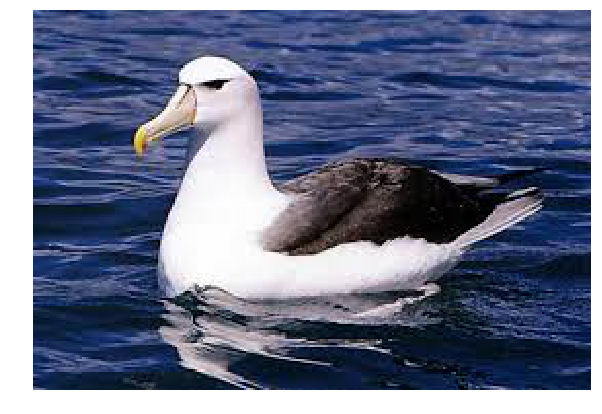

Using Inception_V4 CNN
Prediction: Probability

albatross, mollymawk: 95.33%
goose: 0.04%
hand blower, blow dryer, blow drier, hair dryer, hair drier: 0.03%
breakwater, groin, groyne, mole, bulwark, seawall, jetty: 0.02%
black swan, Cygnus atratus: 0.02%
red-breasted merganser, Mergus serrator: 0.02%
killer whale, killer, orca, grampus, sea wolf, Orcinus orca: 0.02%
screw: 0.02%
grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus: 0.02%
promontory, headland, head, foreland: 0.02%


In [15]:
predict('albatross.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


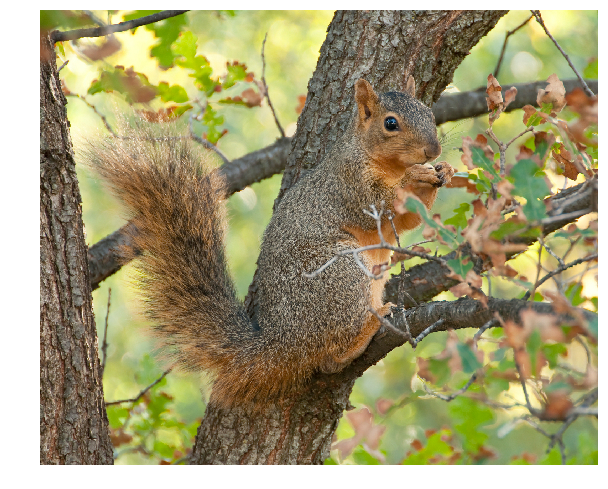

Using Inception_V4 CNN
Prediction: Probability

fox squirrel, eastern fox squirrel, Sciurus niger: 96.91%
mongoose: 0.07%
corn: 0.05%
ear, spike, capitulum: 0.03%
acorn: 0.03%
marmot: 0.02%
red-breasted merganser, Mergus serrator: 0.02%
cicada, cicala: 0.02%
skunk, polecat, wood pussy: 0.02%
banana: 0.02%


In [16]:
predict('squirrel.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


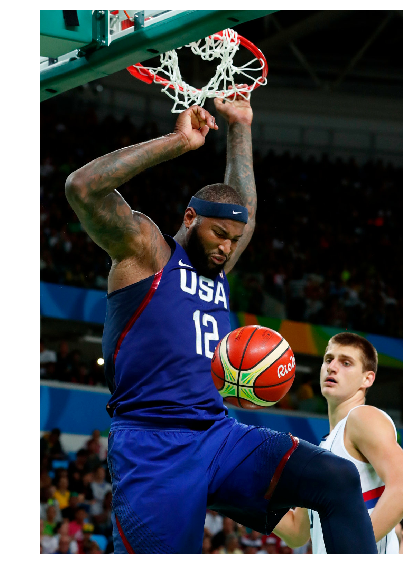

Using Inception_V4 CNN
Prediction: Probability

basketball: 99.80%
fly: 0.00%
tiger, Panthera tigris: 0.00%
football helmet: 0.00%
proboscis monkey, Nasalis larvatus: 0.00%
three-toed sloth, ai, Bradypus tridactylus: 0.00%
chiffonier, commode: 0.00%
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus: 0.00%
ballplayer, baseball player: 0.00%
kuvasz: 0.00%


In [17]:
predict('basketball.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


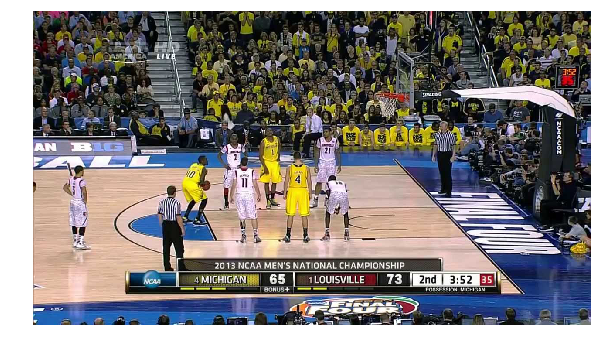

Using Inception_V4 CNN
Prediction: Probability

horizontal bar, high bar: 26.71%
scoreboard: 12.10%
basketball: 7.61%
ballplayer, baseball player: 7.15%
balance beam, beam: 4.04%
parallel bars, bars: 3.67%
volleyball: 2.98%
television, television system: 2.75%
comic book: 2.06%
book jacket, dust cover, dust jacket, dust wrapper: 1.26%


In [18]:
predict('basketball_game.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


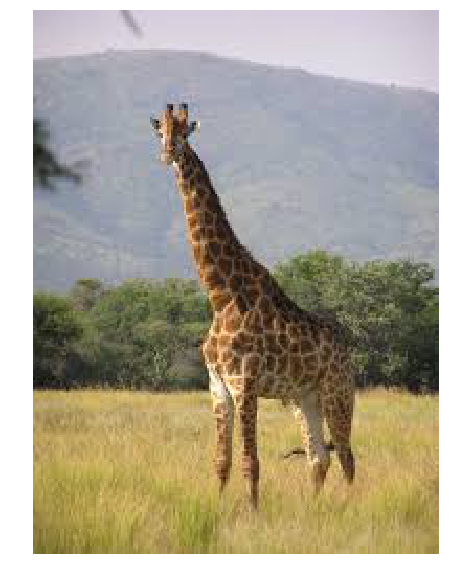

Using Inception_V4 CNN
Prediction: Probability

leopard, Panthera pardus: 64.94%
cheetah, chetah, Acinonyx jubatus: 5.39%
jaguar, panther, Panthera onca, Felis onca: 3.93%
snow leopard, ounce, Panthera uncia: 1.95%
lion, king of beasts, Panthera leo: 1.32%
lynx, catamount: 1.26%
llama: 1.04%
cougar, puma, catamount, mountain lion, painter, panther, Felis concolor: 1.00%
gazelle: 0.81%
hyena, hyaena: 0.64%


In [19]:
predict('giraffe.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


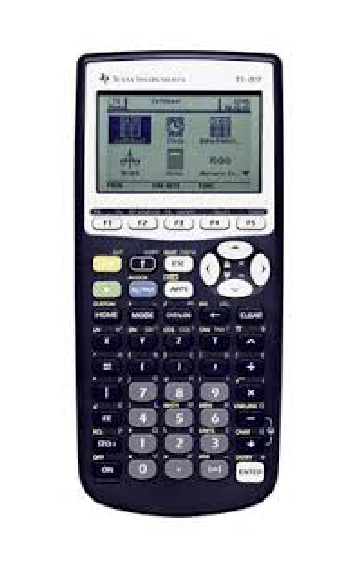

Using Inception_V4 CNN
Prediction: Probability

hand-held computer, hand-held microcomputer: 85.52%
radio, wireless: 1.76%
remote control, remote: 1.07%
cellular telephone, cellular phone, cellphone, cell, mobile phone: 0.77%
oscilloscope, scope, cathode-ray oscilloscope, CRO: 0.65%
space bar: 0.47%
dial telephone, dial phone: 0.28%
tape player: 0.23%
barometer: 0.19%
cassette player: 0.18%


In [20]:
predict('calculator.jpg', version='V4')

INFO:tensorflow:Restoring parameters from models/cnn/inception_v4.ckpt


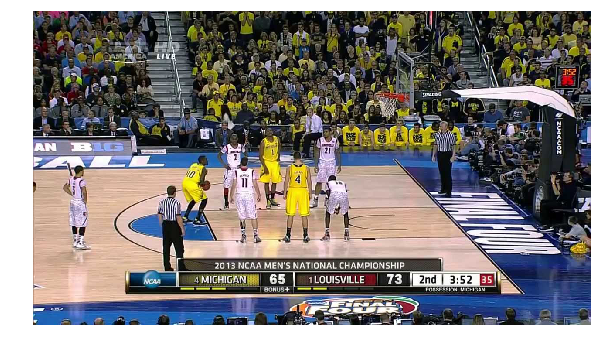

Using Inception_V4 CNN
Prediction: Probability

horizontal bar, high bar: 26.71%
scoreboard: 12.10%
basketball: 7.61%
ballplayer, baseball player: 7.15%
balance beam, beam: 4.04%
parallel bars, bars: 3.67%
volleyball: 2.98%
television, television system: 2.75%
comic book: 2.06%
book jacket, dust cover, dust jacket, dust wrapper: 1.26%


In [21]:
predict('basketball_game.jpg', version='V4')